Theta acceptance rate: 0.770


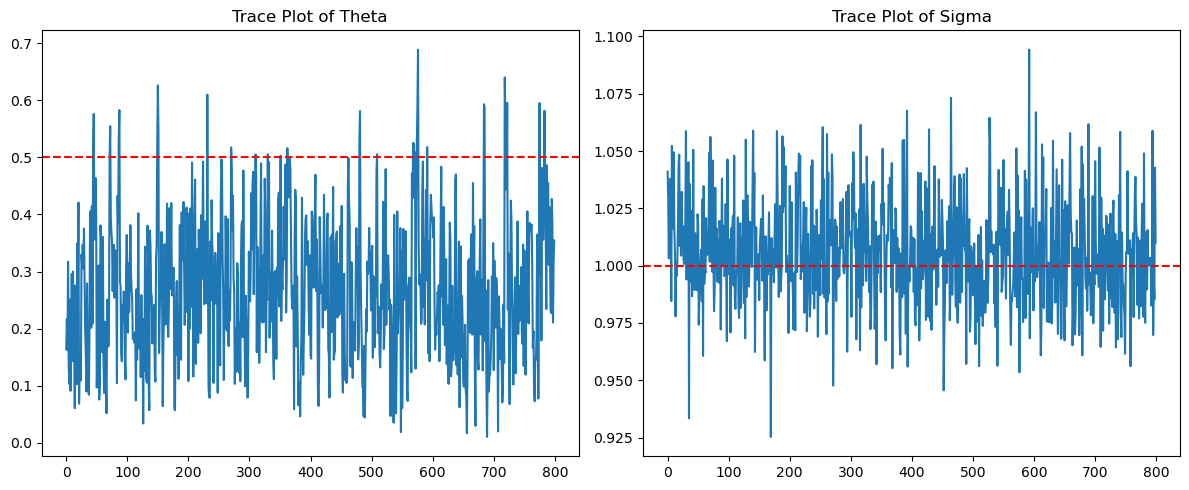

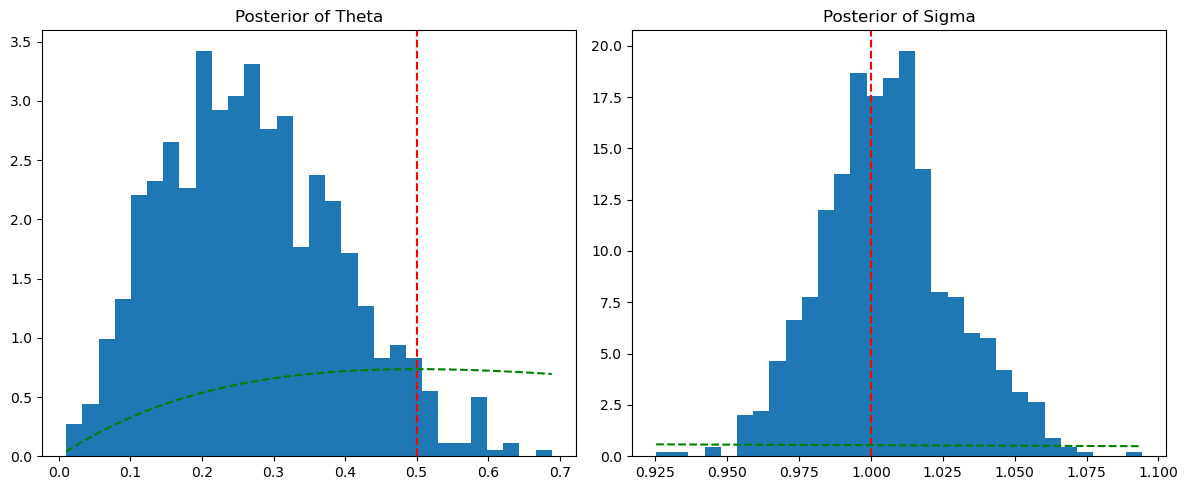

Theta posterior mean: 0.269, True theta: 0.5
Sigma posterior mean: 1.006, True sigma: 1


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Simulate OU process
def simulate_ou(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(n_steps - 1):
        x[i+1] = x[i] + theta * (mu - x[i]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return x

# Log-likelihood
def log_likelihood(theta, mu, sigma, x, dt):
    n = len(x)
    errors = (x[1:] - x[:-1] - theta * (mu - x[:-1]) * dt) / (sigma * np.sqrt(dt))
    log_lik = -0.5 * (n - 1) * np.log(2 * np.pi * sigma**2 * dt) - 0.5 * np.sum(errors**2)
    return log_lik

# Metropolis-Hastings for theta
def metropolis_hastings_theta(theta_current, sigma, x, mu, dt, prior_params, proposal_sd):
    theta_proposed = np.random.normal(theta_current, proposal_sd)
    if theta_proposed <= 0:
        return theta_current, 0
    log_lik_current = log_likelihood(theta_current, mu, sigma, x, dt)
    log_lik_proposed = log_likelihood(theta_proposed, mu, sigma, x, dt)

    log_prior_current = stats.gamma.logpdf(theta_current, a=prior_params[0], scale=1/prior_params[1])
    log_prior_proposed = stats.gamma.logpdf(theta_proposed, a=prior_params[0], scale=1/prior_params[1])

    log_alpha = log_lik_proposed + log_prior_proposed - log_lik_current - log_prior_current
    alpha = np.exp(log_alpha)

    if np.random.uniform() < alpha:
        return theta_proposed, 1
    else:
        return theta_current, 0

# Gibbs sampler
def gibbs_sampler(x, dt, n_iterations, burn_in, thinning, theta_prior_params, sigma_prior_params, proposal_sd_theta, mu=0):
    n = len(x)
    theta_samples = np.zeros(n_iterations)
    sigma_samples = np.zeros(n_iterations)
    theta_samples[0] = 0.5 #initial value
    sigma_samples[0] = 1   #initial value

    acceptance_count = 0
    for i in range(1, n_iterations):
        # Sample theta
        theta_samples[i], accepted = metropolis_hastings_theta(theta_samples[i-1], sigma_samples[i-1], x, mu, dt, theta_prior_params, proposal_sd_theta)
        acceptance_count += accepted
        
        # Sample sigma^2 (using InverseGamma conjugacy)
        alpha_post = sigma_prior_params[0] + (n - 1) / 2
        beta_post = sigma_prior_params[1] + 0.5 * np.sum(((x[1:] - x[:-1] - theta_samples[i] * (mu - x[:-1]) * dt)**2) / dt)
        sigma_squared = stats.invgamma.rvs(a=alpha_post, scale=beta_post)
        sigma_samples[i] = np.sqrt(sigma_squared)

    acceptance_rate = acceptance_count / (n_iterations - 1)
    print(f"Theta acceptance rate: {acceptance_rate:.3f}")

    # Apply burn-in and thinning
    theta_samples = theta_samples[burn_in::thinning]
    sigma_samples = sigma_samples[burn_in::thinning]

    return theta_samples, sigma_samples

# Example Usage
# --- Simulation ---
true_theta = 0.5
true_mu = 0
true_sigma = 1
x0 = 2
dt = 0.01
n_steps = 1000
x = simulate_ou(true_theta, true_mu, true_sigma, x0, dt, n_steps)

# --- Prior parameters ---
theta_prior_params = (2, 2)  # Gamma(alpha, beta) for theta
sigma_prior_params = (2, 2)  # InverseGamma(alpha, beta) for sigma^2

# --- MCMC parameters ---
n_iterations = 5000
burn_in = 1000
thinning = 5
proposal_sd_theta = 0.1

# --- Run Gibbs sampler ---
theta_samples, sigma_samples = gibbs_sampler(x, dt, n_iterations, burn_in, thinning, theta_prior_params, sigma_prior_params, proposal_sd_theta, mu=true_mu)

# --- Diagnostics and Visualization ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(theta_samples)
plt.axhline(y=true_theta, color='r', linestyle='--')
plt.title("Trace Plot of Theta")

plt.subplot(1, 2, 2)
plt.plot(sigma_samples)
plt.axhline(y=true_sigma, color='r', linestyle='--')
plt.title("Trace Plot of Sigma")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(theta_samples, bins=30, density=True)
plt.axvline(x=true_theta, color='r', linestyle='--')
plt.title("Posterior of Theta")
x_grid = np.linspace(theta_samples.min(), theta_samples.max(), 100)
plt.plot(x_grid, stats.gamma.pdf(x_grid, a=theta_prior_params[0], scale=1/theta_prior_params[1]), color = 'g', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, density=True)
plt.axvline(x=true_sigma, color='r', linestyle='--')
plt.title("Posterior of Sigma")
x_grid = np.linspace(sigma_samples.min(), sigma_samples.max(), 100)
plt.plot(x_grid, stats.gamma.pdf(x_grid, a=sigma_prior_params[0], scale=1/sigma_prior_params[1]), color = 'g', linestyle='--')

plt.tight_layout()
plt.show()

print(f"Theta posterior mean: {np.mean(theta_samples):.3f}, True theta: {true_theta}")
print(f"Sigma posterior mean: {np.mean(sigma_samples):.3f}, True sigma: {true_sigma}")


In [2]:
import numpy as np

def simulate_ornstein_uhlenbeck(theta, mu, sigma, x0, dt, n_steps):
  """Simulates an Ornstein-Uhlenbeck process."""
  x = np.zeros(n_steps + 1)
  x[0] = x0
  for i in range(n_steps):
    x[i+1] = x[i] + theta * (mu - x[i]) * dt + sigma * np.sqrt(dt) * np.random.normal()
  return x

def forward_euler_log_likelihood(theta, mu, sigma, x, dt):
  """Computes the log-likelihood of the Ornstein-Uhlenbeck process using Forward Euler."""
  n = len(x) - 1
  variance = sigma**2 * dt
  log_likelihood = -n / 2 * np.log(2 * np.pi * variance)
  for i in range(n):
    residual = x[i+1] - (x[i] + theta * (mu - x[i]) * dt)
    log_likelihood -= residual**2 / (2 * variance)
  return log_likelihood

def exact_log_likelihood(theta, mu, sigma, x, dt):
    """Computes the exact log-likelihood of the Ornstein-Uhlenbeck process."""
    n = len(x) - 1
    
    # Precompute some constants for efficiency
    exp_neg_theta_dt = np.exp(-theta * dt)
    variance_factor = sigma**2 * (1 - np.exp(-2 * theta * dt)) / (2 * theta)
    
    log_likelihood = -n / 2 * np.log(2 * np.pi)
    for i in range(n):
        # Calculate the mean and variance for the conditional distribution
        conditional_mean = x[i] * exp_neg_theta_dt + mu * (1 - exp_neg_theta_dt)
        conditional_variance = variance_factor
        
        # Update the log-likelihood
        log_likelihood -= 0.5 * np.log(conditional_variance)
        residual = x[i+1] - conditional_mean
        log_likelihood -= residual**2 / (2 * conditional_variance)
        
    return log_likelihood

# Example usage:
theta = 0.5
mu = 1.0
sigma = 0.2
x0 = 0.0
dt = 0.1  # Larger time step (sparser measurements)
n_steps = 1000

# Simulate data
x = simulate_ornstein_uhlenbeck(theta, mu, sigma, x0, dt, n_steps)

# Compute log-likelihoods with both methods
log_likelihood_fe = forward_euler_log_likelihood(theta, mu, sigma, x, dt)
log_likelihood_exact = exact_log_likelihood(theta, mu, sigma, x, dt)

print(f"Forward Euler Log-likelihood: {log_likelihood_fe}")
print(f"Exact Log-likelihood: {log_likelihood_exact}")

# Test with even sparser data
dt_sparse = 1.0 # Very large time step
n_steps_sparse = 100

x_sparse = simulate_ornstein_uhlenbeck(theta, mu, sigma, x0, dt_sparse, n_steps_sparse)

log_likelihood_fe_sparse = forward_euler_log_likelihood(theta, mu, sigma, x_sparse, dt_sparse)
log_likelihood_exact_sparse = exact_log_likelihood(theta, mu, sigma, x_sparse, dt_sparse)

print(f"Forward Euler Log-likelihood (sparse): {log_likelihood_fe_sparse}")
print(f"Exact Log-likelihood (sparse): {log_likelihood_exact_sparse}")


Forward Euler Log-likelihood: 1349.1252159317546
Exact Log-likelihood: 1348.9216980842602
Forward Euler Log-likelihood (sparse): 25.759513110487887
Exact Log-likelihood (sparse): 20.261065036372845
